In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import scipy.io as sio
from matplotlib import rc

def set_style_sns():
    sns.set_context('paper')
    sns.set(font = 'serif')
    sns.set(font_scale = 1.3)
    
    sns.set_style('white', {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif'],
        'lines.markersize': 10
    })
    
    
plt.rcParams.update({'font.size':16})
set_style_sns()

plt.rcParams.update({'text.usetex': False})

In [2]:
data = sio.matlab.loadmat('./../data/ece271b_data_select.mat')

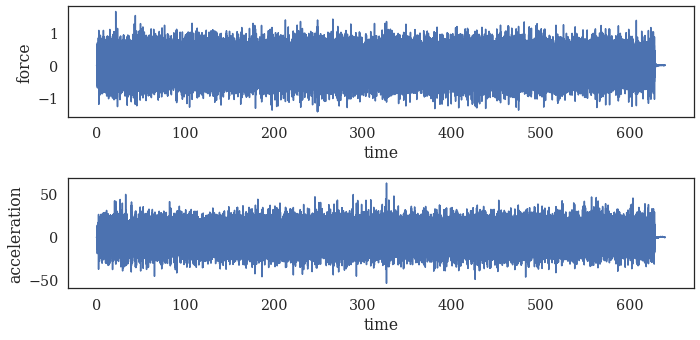

In [3]:
u = np.array(data['u'])
y = np.array(data['y'])
t = np.array(data['time'])[:,0]
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t,u)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

3276


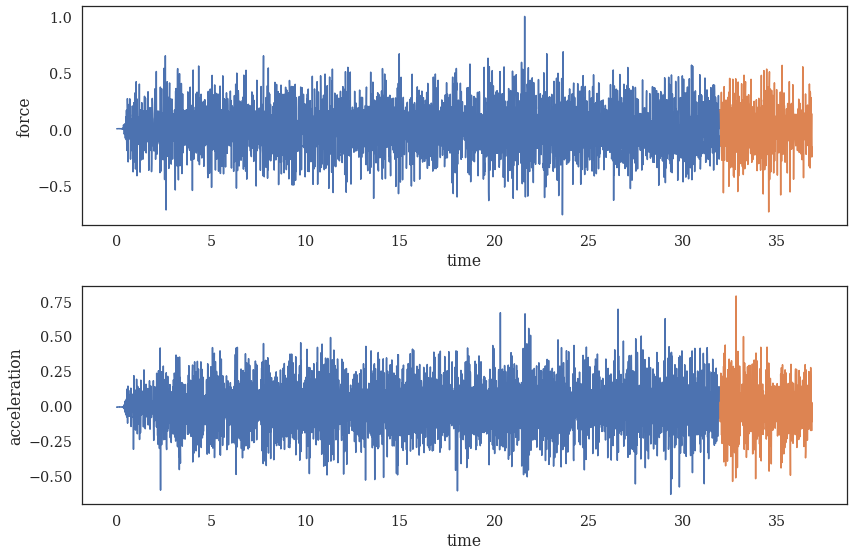

In [102]:
umax = np.max(u)
ymax = np.max(y)

u_norm = u/umax
y_norm = y/ymax

N = len(u)
ntrain = int(N*0.05)

print(ntrain)
utrain = u_norm[:ntrain]
ytrain = y_norm[:ntrain]
ttrain = t[:ntrain]
intrain = np.hstack([utrain,ytrain])

utest = u_norm[ntrain:ntrain+500]
ytest = y_norm[ntrain:ntrain+500]
ttest = t[ntrain:ntrain+500]
intest = np.hstack([utest,ytest])

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(ttrain,utrain)
plt.plot(ttest,utest)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(ttrain,ytrain)
plt.plot(ttest,ytest)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

In [103]:
def create_inout_sequences(input_data, output_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw, :]
        train_label = output_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [134]:
def transform_data(arr_in, arr_out, seq_len):
    x, y = [], []
    seqn = arr_in.shape[1]
    for i in range(len(arr_in) - seq_len):
        x_i = arr_in[i : i + seq_len, :]
        y_i = arr_out[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [163]:
from torch.autograd import Variable

train_window = 30


x_train, y_train = transform_data(ytrain, ytrain, train_window)
x_val, y_val = transform_data(ytest, ytest, train_window)

print(x_train.shape, y_train.shape)

torch.Size([3246, 30]) torch.Size([3246, 30])


In [164]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [165]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.4f. Validation loss: %.4f. Avg future: %.4f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            batch = 1
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [166]:
model_1 = Model(input_size=1, hidden_size=100, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [ ]:
optimization_1.train(x_train, y_train, x_val, y_val, n_epochs = 100, do_teacher_forcing=False)

Epoch 1 Train loss: 0.0334. Validation loss: 0.0460. Avg future: 0.0000. Elapsed time: 7.31s.
Epoch 2 Train loss: 0.0302. Validation loss: 0.0400. Avg future: 0.0000. Elapsed time: 6.98s.
Epoch 3 Train loss: 0.0258. Validation loss: 0.0340. Avg future: 0.0000. Elapsed time: 7.14s.
Epoch 4 Train loss: 0.0235. Validation loss: 0.0409. Avg future: 0.0000. Elapsed time: 7.47s.
Epoch 5 Train loss: 0.0243. Validation loss: 0.0374. Avg future: 0.0000. Elapsed time: 6.50s.
Epoch 6 Train loss: 0.0230. Validation loss: 0.0313. Avg future: 0.0000. Elapsed time: 7.01s.
Epoch 7 Train loss: 0.0216. Validation loss: 0.0310. Avg future: 0.0000. Elapsed time: 7.08s.
Epoch 8 Train loss: 0.0213. Validation loss: 0.0303. Avg future: 0.0000. Elapsed time: 7.31s.
Epoch 9 Train loss: 0.0208. Validation loss: 0.0297. Avg future: 0.0000. Elapsed time: 6.91s.
Epoch 10 Train loss: 0.0203. Validation loss: 0.0291. Avg future: 0.0000. Elapsed time: 6.87s.
Epoch 11 Train loss: 0.0200. Validation loss: 0.0288. Avg f

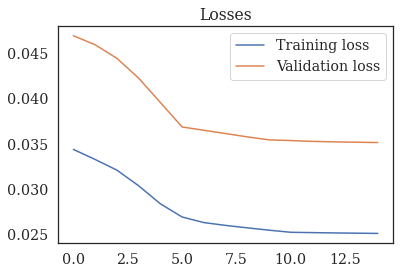

In [152]:
optimization_1.plot_losses()

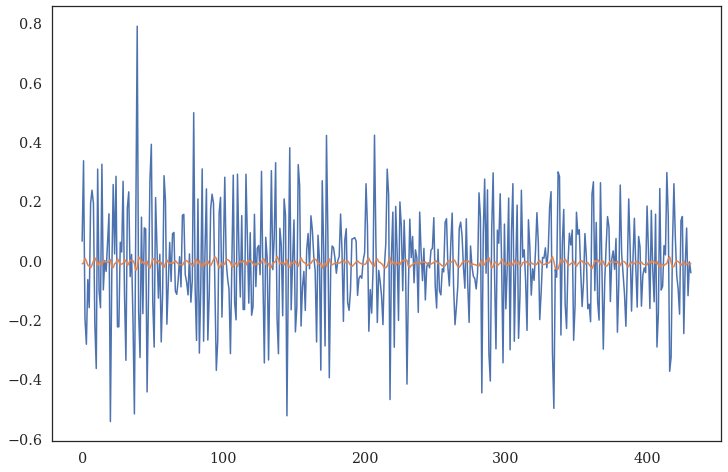

In [161]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_val, y_val, future=5, batch_size=48)
actual_1 = np.array(actual_1)

plt.figure(figsize=(12,8))
plt.plot(actual_1)
plt.plot(predicted_1)
plt.show()


In [156]:
y_val.shape

torch.Size([452, 48])